# Accelerate ResNet18 model with TensorRT on NVIDIA Jetson

Deep learning models, especially convolutional neural networks (CNNs) like ResNet18, are widely used for image classification tasks. However, deploying these models on edge devices such as the NVIDIA Jetson platform requires optimization for efficiency and speed. TensorRT, NVIDIA’s high-performance deep learning inference library, provides a way to accelerate these models by optimizing them for Jetson’s GPU and Tensor Cores.

In this tutorial, we will fine-tune a ResNet18 model using PyTorch and accelerate its inference with TensorRT on [NVIDIA® Jetson Orin Nano™ Developer Kit](https://developer.nvidia.com/embedded/learn/jetson-orin-nano-devkit-user-guide/index.html). We will evaluate performance improvements by measuring inference speed on the Imagenette dataset, a smaller subset of ImageNet designed for rapid experimentation.

Basic software and package versions in this tutorial include:

- **JetPack** - 6.2 (also compatible with 6.1)  
- **CUDA** - 12.6  
- **TensorRT** - 10.3  
- **Python** - 3.10  
- **cuSPARSELt** - 0.7.0  
- **torch** - 2.5 (built from wheel)  
- **torchvision** - 0.20.0

Flash your Jetson device with JetPack, CUDA runtime, and TensorRT with NVIDIA guide. Confirm these packages with:

```sh
$ nvcc --version  # Check CUDA runtime
$ dpkg -l | grep nvinfer  # Check TensorRT packages
```

TensorRT Python SDK can also be verified with:
```sh
$ python
>>> import tensorrt as trt
>>> print(trt.__version__)
```

Additionally, if you are working with a virtual environment, add this package to your path by modifying your `venv/bin/activate` file:

```sh
$ echo 'export LD_LIBRARY_PATH=/usr/lib/aarch64-linux-gnu:$LD_LIBRARY_PATH' >> path_to_your_venv/bin/activate
$ echo 'export PYTHONPATH=/usr/lib/python3.X/dist-packages:$PYTHONPATH' >> path_to_your_venv/bin/activate
```

## Fine-tuning ResNet18 model to Imagenette

Follow NVIDIA official instructions for [flashing Jetson Orin Nano with JetPack 6.2](https://developer.nvidia.com/embedded/jetpack-sdk-62) and installing [PyTorch](https://forums.developer.nvidia.com/t/pytorch-for-jetson/72048). You can also refer to our detailed guide on installing these packages on Jetson device.

Unlike our previous guide, we will use pure PyTorch instead of `fastai` to fine-tune a pretrained ResNet18 model to Imagenette2-320 dataset. This dataset contains 10 categories (labels) compared to the original 1000 output classes in ImageNet, making it a great choice for benchmarking and rapid prototyping.

In [ ]:
#| eval: false
import os
import matplotlib.pyplot as plt
import tarfile
import time
import torch
import urllib.request

from pathlib import Path
from torchvision import datasets, transforms
from torchvision import models
from torchvision import utils as vutils
from tqdm import tqdm

### Prepare Imagenette dataset

To train our ResNet18 model on Imagenette, we first need to download and extract the dataset. The fastai library provides a convenient link to the dataset, which we can use to retrieve it directly.

In [ ]:
#| eval: false
# Check if the dataset has already been downloaded; if not, download and extract it
# Define the URL for Imagenette-320 dataset and the path where it should be saved
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
data_dir = Path.cwd() / 'data'  # Use current working directory for data storage
dataset_path = data_dir / "imagenette2-320"

# Check if the dataset has already been downloaded; if not, download and extract it
if not dataset_path.exists():
    data_dir.mkdir(parents=True, exist_ok=True)
    
    # Download the dataset
    tar_path = data_dir / "imagenette2-320.tgz"
    urllib.request.urlretrieve(dataset_url, tar_path)
    
    # Extract the tar.gz file
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=data_dir)
    
    # Remove the tar.gz file after extraction
    os.remove(tar_path)

[ child for child in dataset_path.iterdir() ]

[PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/noisy_imagenette.csv'),
 PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/val'),
 PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/train')]

Imagenette2-320 is available as a structured directory of images. We use `torchvision.datasets.ImageFolder` to load the dataset, applying standard image preprocessing and data augmentation using `torchvision.transforms`.

Training samples: 9469
Validation samples: 3925
Number of classes: 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


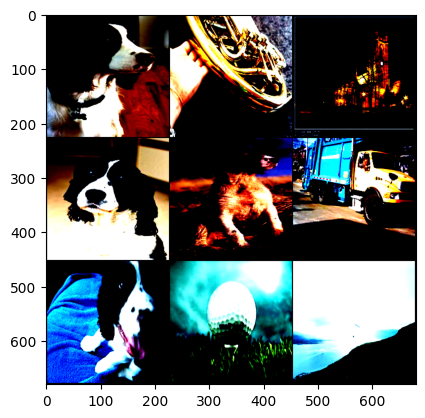

In [ ]:
#| eval: false
# Define the image transformations (resize and normalize)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize all images to 224x224 (height, width)
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip to some images
    transforms.ToTensor(),              # Convert images to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),     # Normalize with ImageNet stats
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),              
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),    
])

# Load the training and validation datasets
train_dataset = datasets.ImageFolder(root=dataset_path / 'train', transform=train_transform)
val_dataset = datasets.ImageFolder(root=dataset_path / 'val', transform=val_transform)

# Create data loaders for training and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Check the number of images in the training and validation sets
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Check the number of classes in the dataset
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Display a batch of images
def show_batch(loader):
    # Get one batch of images
    images, labels = next(iter(loader))
    # Convert the batch of images to a grid of images
    grid = vutils.make_grid(images[:9], nrow=3)
    # Plot the grid of images
    plt.imshow(grid.permute(1, 2, 0).numpy())  # Permute to (H, W, C) for matplotlib
    plt.show()

# Show a batch from the training set
show_batch(train_loader)

### Fine-tune pretrained model

To prepare the model, we will first load a pretrained ResNet18 model from PyTorch's `torchvision` library, and then set up the model for training on the appropriate device (either GPU or CPU).

In [ ]:
#| eval: false
# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model set to device: {device}")

Model set to device: cuda


Next, we set up some additional utilities for training and validating the model, including:

- class `Recorder`: save training / validating durations, losses, and accuracy values in each epoch.  
- `train`: Custom function to train the model using One-Cycle learning rate policy.  
- `validate`: Custom function to validate the model.

In [ ]:
#| eval: false
class Recorder:
    """A class to record the training and validation metrics"""
    def __init__(self):
        self.durations = []
        self.losses = []
        self.accuracies = []

    def append(self, duration, loss, accuracy):
        self.durations.append(duration)
        self.losses.append(loss)
        self.accuracies.append(accuracy)

In [ ]:
#| eval: false
def train(model, train_loader, criterion, optimizer, epochs, lr_max, pct_start, div, device, recorder=None):
    """Train the model using a One-Cycle learning rate policy."""
    # Prepare the OneCycleLR scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=lr_max, 
        total_steps=len(train_loader)*epochs, 
        pct_start=pct_start, 
        div_factor=div)

    model.train()
    for epoch in range(epochs):
        # Initialize variables to track the loss and accuracy
        running_loss = 0.0
        running_corrects = 0
        start_time = time.time()

        # Progress bar for the training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        # Iterate over the training dataset
        for inputs, labels in progress_bar:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Compute the loss and accuracy
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        # Record the training metrics
        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        if recorder:
            # Append the metrics to the Recorder object
            recorder.append(epoch_time, epoch_loss, epoch_acc)

        # Display the training metrics
        print(f"Epoch {epoch+1}/{epochs}, Duration: {epoch_time:.0f}s, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [ ]:
#| eval: false
def validate(model, val_loader, criterion, device, recorder=None):
    """Validate the model and return loss and accuracy."""
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track the loss, accuracy, and duration
    running_loss = 0.0
    running_corrects = 0
    start_time = time.time()
    
    # Progress bar for the validation loop
    progress_bar = tqdm(val_loader, desc="Validating", leave=False)
    
    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            progress_bar.set_postfix(loss=loss.item())
    
    # Record the validation metrics
    val_time = time.time() - start_time
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)
    if recorder:
        recorder.append(val_time, val_loss, val_acc)
    
    print(f"Validation, Duration: {val_time:.0f}s, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    return val_loss, val_acc  # Return the loss and accuracy

The fine-tuning process for a pretrained model, like ResNet18, is typically done in two phases to effectively adapt the model to a new dataset. These phases are:

#### Phase 1: Train the Last Layer Only
In the first phase, we focus on training only the newly added fully connected (FC) layer, while freezing all other layers of the pretrained model. This helps the model quickly adapt to the new dataset without altering the general feature representations learned from ImageNet.

- **Freeze Pretrained Layers**: We freeze all layers except for the final FC layer so that their weights are not updated during training.  
- **Modify the Final Layer**: The final FC layer is replaced to match the number of classes in the new dataset (e.g., 10 classes for Imagenette).  
- **Set Up the Optimizer**: The optimizer is set up to update only the parameters of the new FC layer, with a suitable learning rate (base_lr).  
- **Train the New Head**: The model is trained for a few epochs (e.g., 1 epoch) to fine-tune just the final layer. This allows the model to adjust the classifier to the new dataset without altering the feature extractor.  

In [ ]:
#| eval: false
# Set up parameters for fine-tuning
epochs=3            # Number of epochs to train the whole model
freeze_epochs=1     # Number of epochs to train the last layer only
base_lr=2e-3        # Base learning rate
lr_mult=100         # Multiplier for the last layer's learning rate
pct_start=0.3       # Percentage of epochs to increase the learning rate
div=5.0             # Factor to divide the learning rate at the end of the one

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
#| eval: false
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.fc.parameters(), lr=base_lr)

# Train the model with the new head
print(f"Training the last layer only for {freeze_epochs} epochs...")
train(model, train_loader, criterion, optimizer, freeze_epochs, base_lr, pct_start, div, device)

Training the last layer only for 1 epochs...


Epoch 1/1, Duration: 109s, Loss: 0.5235, Accuracy: 0.8792


#### Phase 2: Fine-tune the Entire Model
In the second phase, we unfreeze all layers of the pretrained model, including the feature extractor, and train the entire network on the new dataset. This allows the model to fine-tune not only the classifier but also the feature extraction layers, adapting more specifically to the new dataset.

- **Unfreeze All Layers**: After training the classifier, all layers of the model are unfrozen, allowing their weights to be updated during training.
- **Adjust Optimizer**: A new optimizer is set up, typically with a lower learning rate for fine-tuning (often scaled by a factor, like lr_mult).
- **Train the Full Model**: The model is then trained for several more epochs (e.g., 3 epochs) to fine-tune the entire network on the new dataset. This helps the model adapt the low- and high-level features to the new task.

In [ ]:
#| eval: false
# Unfreeze all the layers
for param in model.parameters():
    param.requires_grad = True

# Adam optimizer for full model
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr/lr_mult)

# Train the full model
print(f"Fine-tuning the full model for {epochs} epochs...")
train_recorder = Recorder()
train(model, train_loader, criterion, optimizer, epochs, base_lr, pct_start, div, device, train_recorder)

Fine-tuning the full model for 3 epochs...


Epoch 1/3:   0%|                                        | 0/148 [00:00<?, ?it/s]

Epoch 1/3, Duration: 115s, Loss: 0.5454, Accuracy: 0.8372


Epoch 2/3, Duration: 114s, Loss: 0.4305, Accuracy: 0.8687


Epoch 3/3, Duration: 113s, Loss: 0.1415, Accuracy: 0.9559


Lastly, evaluate model performance on the validation dataset:

In [ ]:
#| eval: false
print("Validating the model...")
val_recorder = Recorder()
validate(model, val_loader, criterion, device, val_recorder)

Validating the model...


Validation, Duration: 48s, Loss: 0.2068, Accuracy: 0.9332


(0.2067526589381467, tensor(0.9332, device='cuda:0', dtype=torch.float64))

Save model to use in different sessions:

In [ ]:
#| eval: false
model.eval()

# Create 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model to a file
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
torch.save(model.state_dict(), model_path)

## Acceleration with Torch-TensorRT

[Torch-TensorRT](https://github.com/pytorch/TensorRT) is an integration of NVIDIA TensorRT with PyTorch, designed to accelerate inference on NVIDIA GPUs with minimal code changes. It optimizes PyTorch models by converting them into TensorRT-optimized modules, significantly improving inference speed—often up to 5x faster than standard PyTorch execution.

### Installation

For Jetson devices, the library needs to be built natively. The general directions are:

1. Install Bazel according to [this tutorial](https://www.forecr.io/blogs/installation/how-to-install-bazel).  
2. Clone a suitable version (branch) of Torch-TensorRT based on your JetPack and TensorRT versions.  
3. Modify configurations in WORKSPACE file or Bazel build file.  
4. Build and install with `bazel` or `pip` commands.

For JetPack < 6, follow the [official guide](https://pytorch.org/TensorRT/getting_started/installation.html), specifically at the section named "Building Natively on aarch64 (Jetson)". For JetPack 6.1 (CUDA 12.6 and TensorRT 10.3), clone the branch `release/2.5` and follow these [instructions](https://pytorch.org/TensorRT/getting_started/jetpack.html).

```sh
# Install Bazel
$ wget -v https://github.com/bazelbuild/bazelisk/releases/download/v1.20.0/bazelisk-linux-arm64
$ sudo mv bazelisk-linux-arm64 /usr/bin/bazel
$ chmod +x /usr/bin/bazel

# Clone github repository
$ git clone -b release/2.5 https://github.com/pytorch/TensorRT
$ cd TensorRT

# Install dependencies
$ pip install -r toolchains/jp_workspaces/requirements.txt

# Modify Bazel build file
$ cuda_version=$(nvcc --version | grep Cuda | grep release | cut -d ',' -f 2 | sed -e 's/ release //g')
$ export TORCH_INSTALL_PATH=$(python -c "import torch, os; print(os.path.dirname(torch.__file__))")
$ export SITE_PACKAGE_PATH=${TORCH_INSTALL_PATH::-6}
$ export CUDA_HOME=/usr/local/cuda-${cuda_version}/
$ cat toolchains/jp_workspaces/MODULE.bazel.tmpl | envsubst > MODULE.bazel  # replace the MODULE.bazel with the jetpack one

# Build and install
$ python setup.py install --user  # Note: remove flag --user if installing in virtual environment
```

In [ ]:
#| eval: false
import time
import torch
import torch_tensorrt
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import datasets, transforms
from torchvision import models
from tqdm import tqdm

### Preparing validation set and loading models

After installation, we can use the library to compile and optimize inference of our PyTorch model. To examine the accelerated efficiency, we will compile our fine-tuned ResNet18 model and compare its performance on the validation set of Imagenette2-320. Prepare a validation dataloader and load our saved model:

In [ ]:
#| eval: false
def get_validation_loader(dataset_path, batch_size=16):
    """Load the validation dataset and return a DataLoader."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_dataset = datasets.ImageFolder((dataset_path / 'val'), transform=transform)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return val_loader

In [ ]:
#| eval: false
# Load the model
def load_model(
        model_path, 
        device = 'cuda',    # Use 'cuda' if GPU is available, else use 'cpu'
        num_classes = 10,   # Number of classes in the dataset imagenette2-320
        use_fp16 = False,   # Use FP16 precision for TensorRT
):
    """Load the model from the specified path and set it to evaluation mode."""
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    if use_fp16:
        model = model.half()
    model.to(device).eval()
    return model

In [ ]:
#| eval: False
# Load the validation dataset with batch size 1
dataset_path = Path.cwd() / 'data' / 'imagenette2-320'
val_dataset = get_validation_loader(dataset_path, batch_size=1)

# Load the baseline model in FP32 and FP16
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
baseline_fp32 = load_model(model_path, use_fp16=False)
baseline_fp16 = load_model(model_path, use_fp16=True)

  model.load_state_dict(torch.load(model_path))



### `torch.compile` with Torch-TensorRT backend

Torch-TensorRT can be used as a backend for `torch.compile`, introduced in PyTorch 2.0, to optimize model execution on NVIDIA GPUs. This integration enables faster inference by leveraging TensorRT’s advanced optimizations, such as kernel fusion and mixed precision (FP16/INT8), while keeping the flexibility of PyTorch.

In [ ]:
#| eval: false
def compile_model(model, use_fp16=False, device='cuda'):
    """Compile the model using TensorRT."""
    # Set the model to evaluation
    model.eval().to(device)

    # Convert the model to TensorRT
    compiled_model = torch.compile(
        model, 
        backend="torch_tensorrt",
        options={
            "truncate_long_and_double": True,
            "enabled_precisions": {torch.half} if use_fp16 else {torch.float},
            "min_block_size": 2,
            "torch_executed_ops": {"torch.ops.aten.sub.Tensor"},
            "optimization_level": 4,
            "use_python_runtime": False,
        },
        dynamic=False
    )

    # Sample input
    inputs = torch.randn((1, 3, 224, 224)).to(device)
    if use_fp16:
        inputs = inputs.half()
    compiled_model(inputs)  # Run the model once to compile it

    # Return the compiled model
    return compiled_model

In [ ]:
#| eval: false
# Compile the baseline models
compiled_fp32 = compile_model(baseline_fp32, use_fp16=False)
compiled_fp16 = compile_model(baseline_fp16, use_fp16=True)

Compare the performance of these models on validation set:

In [ ]:
#| eval: false
def evaluate_model(model, dataloader, device, use_fp16=False):
    """Evaluate accuracy & inference time for a given batch size"""
    # Initialize variables to track the total time and correct predictions
    total_time = 0.0
    running_corrects = 0

    # Set the model to evaluation mode
    progress_bar = tqdm(dataloader, desc="Evaluating performance...", leave=False)
    
    for inputs, labels in progress_bar:
            if use_fp16:  # Convert inputs to half precision
                inputs = inputs.half()
        
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # Measure the inference time
            start_time = time.time()
            outputs = model(inputs)
            total_time += time.time() - start_time

            # Compute the accuracy
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    # Calculate the inference accuracy and average time
    inf_acc = float(running_corrects.double() / len(dataloader.dataset))
    avg_time = total_time / len(dataloader.dataset)

    return inf_acc, total_time, avg_time

In [ ]:
#| eval: false
# Evaluate the baseline models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
baseline_fp32_acc, baseline_fp32_time, baseline_fp32_avg = evaluate_model(baseline_fp32, val_dataset, device, use_fp16=False)
baseline_fp16_acc, baseline_fp16_time, baseline_fp16_avg = evaluate_model(baseline_fp16, val_dataset, device, use_fp16=True)

# Evaluate the compiled models
compiled_fp32_acc, compiled_fp32_time, compiled_fp32_avg = evaluate_model(compiled_fp32, val_dataset, device, use_fp16=False)
compiled_fp16_acc, compiled_fp16_time, compiled_fp16_avg = evaluate_model(compiled_fp16, val_dataset, device, use_fp16=True)

# Display the results
results = {
    "Model": ["Baseline (FP32)", "Baseline (FP16)", "Compiled (FP32)", "Compiled (FP16)"],
    "Accuracy": [baseline_fp32_acc, baseline_fp16_acc, compiled_fp32_acc, compiled_fp16_acc],
    "Total Time": [baseline_fp32_time, baseline_fp16_time, compiled_fp32_time, compiled_fp16_time],
    "Average Time": [baseline_fp32_avg, baseline_fp16_avg, compiled_fp32_avg, compiled_fp16_avg]
}
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Total Time,Average Time
0,Baseline (FP32),0.933248,42.226567,0.010758
1,Baseline (FP16),0.933248,47.002227,0.011975
2,Compiled (FP32),0.933248,9.220223,0.002349
3,Compiled (FP16),0.933248,8.336410,0.002124


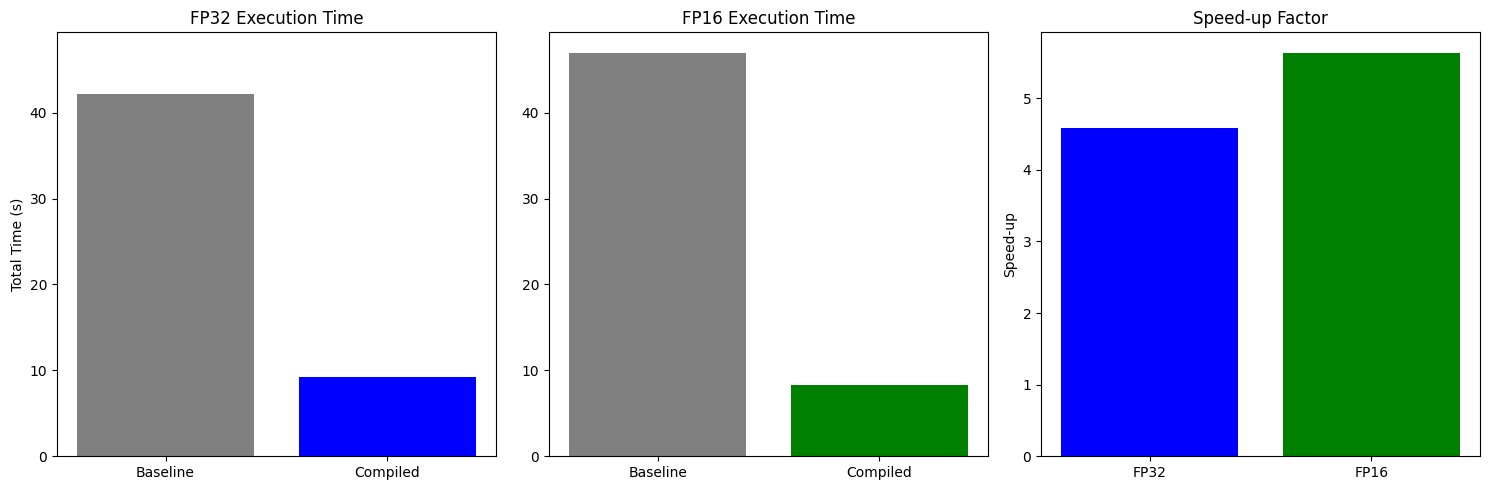

In [ ]:
#| eval: false
speedup = [baseline_fp32_time / compiled_fp32_time, baseline_fp16_time / compiled_fp16_time]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# FP32 Speed Comparison
axes[0].bar(["Baseline", "Compiled"], [baseline_fp32_time, compiled_fp32_time], color=['gray', 'blue'])
axes[0].set_title('FP32 Execution Time')
axes[0].set_ylabel('Total Time (s)')

# FP16 Speed Comparison
axes[1].bar(["Baseline", "Compiled"], [baseline_fp16_time, compiled_fp16_time], color=['gray', 'green'])
axes[1].set_title('FP16 Execution Time')

# Link the y-axis of the first two subplots
axes[0].set_ylim(axes[1].get_ylim())

# Speed-up Factor
axes[2].bar(["FP32", "FP16"], speedup, color=['blue', 'green'])
axes[2].set_title('Speed-up Factor')
axes[2].set_ylabel('Speed-up')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The results demonstrate that TensorRT compilation significantly improves inference speed without impacting accuracy. Both FP32 and FP16 models achieve an accuracy of 0.933248, showing that optimization does not degrade performance.

In terms of execution time:

- The compiled FP32 model is 4.6× faster than the baseline.  
- The compiled FP16 model is 5.6× faster than the baseline.  

The speed-up indicates that TensorRT efficiently optimizes both FP32 and FP16 models, with FP16 providing a slight additional boost.

### Compiling with dynamic shapes (batch sizes)

In the previous part, we tested with a fixed batch size of 1. However, models with larger batch sizes require re-compilation to handle dynamic input shapes effectively. This section will cover how to compile models for varying batch sizes while maintaining performance.

In [ ]:
#| eval: false
def compile_dynamic_model(model, use_fp16=False, device='cuda'):
    """Compile the model using TensorRT with dynamic input shapes."""
    # Set the model to evaluation
    model.eval().to(device)

    # Convert the model to TensorRT
    compile_spec = {
        "inputs": [
            torch_tensorrt.Input(
                min_shape=(1, 3, 224, 224),
                opt_shape=(8, 3, 224, 224),
                max_shape=(64, 3, 224, 224),
                dtype=torch.half if use_fp16 else torch.float
            )
        ],
        "enabled_precisions": {torch.half if use_fp16 else torch.float},
        "ir": "dynamo",
        "min_block_size": 2,
        "torch_executed_ops": {"torch.ops.aten.sub.Tensor"},
        "optimization_level": 4,
        "use_python_runtime": False,
    }
    compiled_model = torch_tensorrt.compile(model, **compile_spec)

    # Sample input
    inputs = torch.randn((1, 3, 224, 224)).to(device)
    if use_fp16:
        inputs = inputs.half()
    compiled_model(inputs)  # Run the model once to compile it

    # Return the compiled model
    return compiled_model

In [ ]:
#| eval: false
# Compile the dynamic models
compiled_fp32_dynamic = compile_dynamic_model(baseline_fp32, use_fp16=False)
compiled_fp16_dynamic = compile_dynamic_model(baseline_fp16, use_fp16=True)

In [ ]:
#| eval: false
# Initialize inference results and batches
results = []
batch_sizes = [1, 8, 16, 32, 64]

# Evaluate the dynamic models with different batch sizes
for batch_size in batch_sizes:
    val_dataset = get_validation_loader(dataset_path, batch_size=batch_size)

    # Evaluate the baseline models
    baseline_fp32_acc, baseline_fp32_time, baseline_fp32_avg = evaluate_model(baseline_fp32, val_dataset, device, use_fp16=False)
    baseline_fp16_acc, baseline_fp16_time, baseline_fp16_avg = evaluate_model(baseline_fp16, val_dataset, device, use_fp16=True)
    
    # Evaluate the compiled models
    compiled_fp32_dynamic_acc, compiled_fp32_dynamic_time, compiled_fp32_dynamic_avg = evaluate_model(compiled_fp32_dynamic, val_dataset, device, use_fp16=False)
    compiled_fp16_dynamic_acc, compiled_fp16_dynamic_time, compiled_fp16_dynamic_avg = evaluate_model(compiled_fp16_dynamic, val_dataset, device, use_fp16=True)
    
    # Append the results
    results.append({
        "Batch Size": batch_size,
        "Baseline (FP32)": baseline_fp32_time,
        "Baseline (FP16)": baseline_fp16_time,
        "Compiled (FP32)": compiled_fp32_dynamic_time,
        "Compiled (FP16)": compiled_fp16_dynamic_time,
        "Speedup (FP32)": baseline_fp32_time / compiled_fp32_dynamic_time,
        "Speedup (FP16)": baseline_fp16_time / compiled_fp16_dynamic_time
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df

,Batch Size,Baseline (FP32),Baseline (FP16),Compiled (FP32),Compiled (FP16),Speedup (FP32),Speedup (FP16)
0,1,39.877589,43.025864,7.746608,12.162015,5.147749,3.537725
1,8,5.470798,5.809673,1.070777,1.900863,5.109185,3.056335
2,16,3.052588,3.236217,0.540771,0.923493,5.644878,3.504322
3,32,1.851204,1.686645,0.277671,0.481308,6.666890,3.504298
4,64,7.253268,1.906956,1.476795,0.848302,4.911492,2.247968


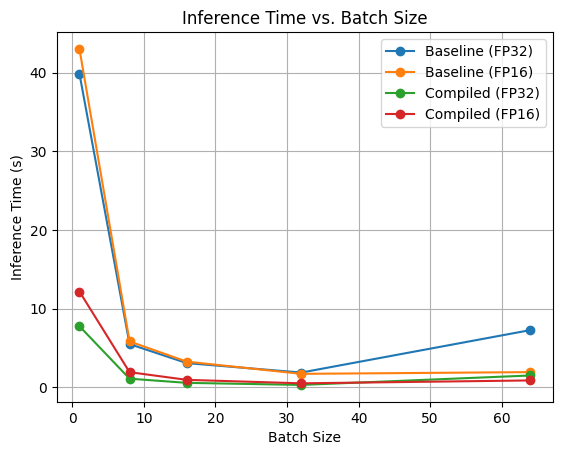

In [ ]:
#| eval: false
# Plot the inference time vs. batch size
plt.figure()
plt.plot(results_df["Batch Size"], results_df["Baseline (FP32)"], marker='o', linestyle='-', label="Baseline (FP32)")
plt.plot(results_df["Batch Size"], results_df["Baseline (FP16)"], marker='o', linestyle='-', label="Baseline (FP16)")
plt.plot(results_df["Batch Size"], results_df["Compiled (FP32)"], marker='o', linestyle='-', label="Compiled (FP32)")
plt.plot(results_df["Batch Size"], results_df["Compiled (FP16)"], marker='o', linestyle='-', label="Compiled (FP16)")

# Labels and Title
plt.xlabel("Batch Size")
plt.ylabel("Inference Time (s)")
plt.title("Inference Time vs. Batch Size")
plt.legend()
plt.grid(True)
plt.show()

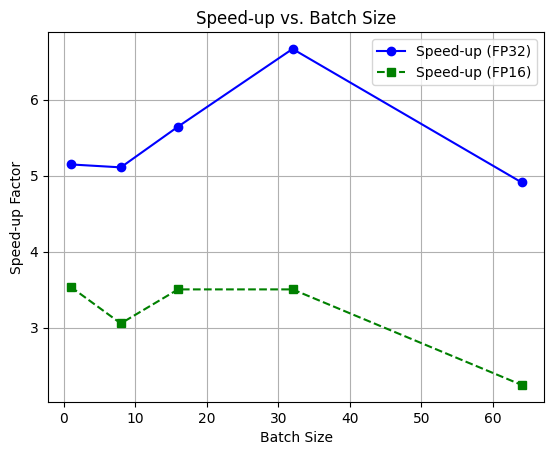

In [ ]:
#| eval: false
# Plot the speed-up factor vs. batch size
plt.figure()
plt.plot(results_df["Batch Size"], results_df["Speedup (FP32)"], marker='o', linestyle='-', color='blue', label="Speed-up (FP32)")
plt.plot(results_df["Batch Size"], results_df["Speedup (FP16)"], marker='s', linestyle='--', color='green', label="Speed-up (FP16)")
plt.xlabel("Batch Size")
plt.ylabel("Speed-up Factor")
plt.title("Speed-up vs. Batch Size")
plt.legend()
plt.grid(True)
plt.show()

The results demonstrate that TensorRT compilation significantly improves inference speed across different batch sizes while maintaining accuracy.

- For FP32 models, the compiled version achieves a speed-up of ~5× to 6.7× compared to the baseline, with the highest gain at batch size 32 (6.67×).  
- For FP16 models, the compiled version also improves performance but with slightly lower speed-up factors, ranging from ~2.25× to 3.54×. Note that this might be due to support for dynamic shapes is inefficient for this device or not fully supported yet.    

Interestingly, at batch size 64, the FP32 baseline experiences a performance drop, while the FP16 baseline remains more stable. This suggests that FP16 benefits from lower memory bandwidth usage, making it more efficient at higher batch sizes.

## Acceleration with ONNX Runtime with TensorRT execution provider

Alternative to Torch-TensorRT, another option to accelerate models is by using [ONNX Runtime](https://onnxruntime.ai/) with the TensorRT execution provider. This integration optimizes ONNX models for NVIDIA GPUs, leveraging TensorRT’s advanced techniques like precision calibration (FP16, INT8), layer fusion, and kernel auto-tuning. It provides a seamless way to achieve high-performance inference with reduced latency and improved efficiency across various deployment environments.

### Installation

First install the dependencies for converting PyTorch model to ONNX and installing ONNX runtime, including:

```sh
$ pip install "numpy<2"   # Downgrade numpy version
$ pip install onnx
$ pip install onnxscript
$ pip install onnxruntime
```

From the ONNX model, [ONNX Runtime](https://onnxruntime.ai/) supports Python API for running inference that can be accelerated with TensorRT as its execution context. TensorRT has to be installed beforehand, and its path should be set with:

```sh
$ export LD_LIBRARY_PATH=/usr/lib/aarch64-linux-gnu:$LD_LIBRARY_PATH
```

Then, `onnxruntime_gpu` needs to be installed via a custom wheel provided by NVIDIA for Jetson devices. Follow this [link](https://pypi.jetson-ai-lab.dev/), select the JetPack and CUDA of your device, and download a suitable wheel depending on the Python version. For example, with JetPack 6+, CUDA 12.6, and Python=3.10, `onnxruntime_gpu==1.20.0` will be installed in this tutorial:

```sh
$ wget https://pypi.jetson-ai-lab.dev/jp6/cu126/+f/0c4/18beb3326027d/onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl#sha256=0c418beb3326027d83acc283372ae42ebe9df12f71c3a8c2e9743a4e323443a4
$ pip install onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl

```

Verify the installation with:

In [ ]:
#| eval: false
import onnxruntime as ort
print(ort.get_device())                 # Should print 'GPU' or 'CPU'
print(ort.get_available_providers())    # Should print 
# ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


### Exporting PyTorch model to ONNX

Start by loading the original PyTorch model:

In [ ]:
#| eval: false
import time
import torch
import torch.onnx
import numpy as np
import onnxruntime as ort
import os
import random

from PIL import Image
from pathlib import Path
from torchvision import models

In [ ]:
#| eval: false
# Load the model
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Change the output layer to 10 classes
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

print(f"Model set to device: {device}")

/tmp/ipykernel_2344/1604416608.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model set to device: cuda


Export the model to ONNX format using torch.onnx:

In [ ]:
#| eval: false
# Define a dummy input with the shape (1, 3, 224, 224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Move the dummy input to the same device as the model

# Define the path for the ONNX export
onnx_model_path = "models/resnet18_imagenette.onnx"  # Save to 'models' directory

# Export the model to ONNX format
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_model_path, 
    input_names=["input"], 
    output_names=["output"]
)

print(f"Original pre-trained model exported to {onnx_model_path}")

Original pre-trained model exported to models/resnet18_imagenette.onnx


### Preparing validation set

For consistency, we continue using the validation set from Imagenette2-320. However, this time we write a custom load image function that transform an image into suitable numpy arrays for inference with ONNX runtime.

Categories: n01440764, n02102040, n02979186, n03000684, n03028079, n03394916, n03417042, n03425413, n03445777, n03888257
Number of validation images: 3925
Image from category n03425413 (index 7): n03425413_17591.JPEG


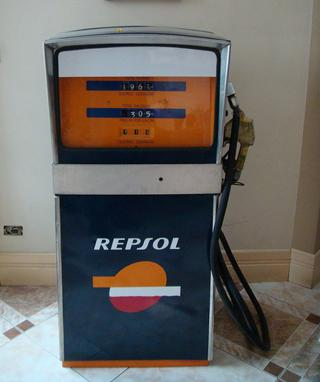

In [ ]:
#| eval: false
# Load the dataset and categories
dataset_path = Path.cwd() / 'data' / 'imagenette2-320'
categories = sorted(os.listdir(dataset_path / 'train'))
print(f"Categories: {', '.join(categories)}")

# Construct random samples from each category 
val_data = list((dataset_path / 'val').rglob('*.JPEG'))
print(f"Number of validation images: {len(val_data)}")

# Load a sample image
image_path = val_data[random.randint(0, len(val_data))]
print(f"Image from category {image_path.parent.name} (index {categories.index(image_path.parent.name)}): {image_path.name}")
Image.open(image_path)

In [ ]:
#| eval: false
def load_image(image_path, target_size=(224, 224)):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image).astype(np.float32)

    # Normalize the image (ResNet-18 normalization mean and std values)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    image_array = (image_array / 255.0 - mean) / std

    # Reshape to (1, 3, 224, 224) as expected by the model
    image_array = np.transpose(image_array, (2, 0, 1))  # HWC -> CHW
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

image_array = load_image(image_path)
image_array.shape

(1, 3, 224, 224)

### Construct different sessions and evaluate TensorRT backend performance

In this tutorial, construct multiple sessions between different execution providers: TensorRT, CUDA, and CPU. This comparison highlights the speed-up provided by TensorRT compared to the standard processing times of CPU and GPU.

In [ ]:
#| eval: false
def run_inference(session, image_array):
    """Run inference, apply softmax, and get the predicted class."""
    # Get input and output names
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Run inference
    logits = session.run([output_name], {input_name: image_array})[0]
    
    # Apply softmax to logits to get probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    
    # Get the predicted class
    predicted_class = np.argmax(probabilities)
    
    return predicted_class, probabilities

In [ ]:
#| eval: false
# Define the path to the exported ONNX model
onnx_model_path = "models/resnet18_imagenette.onnx"

# Construct multiple InferenceSession objects with different providers
cpu_session = ort.InferenceSession(onnx_model_path)
cuda_session = ort.InferenceSession(
    onnx_model_path, 
    providers=[
        ("CUDAExecutionProvider", {
            "device_id": 0,                                 # Use the first available GPU
            "arena_extend_strategy": "kNextPowerOfTwo",     # Efficient memory management
            "gpu_mem_limit": 2 * 1024 * 1024 * 1024,        # Limit memory usage (adjust for Jetson Nano)
            "cudnn_conv_algo_search": "EXHAUSTIVE",         # Optimize convolution algorithms
            "do_copy_in_default_stream": True,              # Reduce synchronization overhead
        })
    ]
)
trt_session = ort.InferenceSession(
    onnx_model_path, 
    providers=[
        ('TensorrtExecutionProvider', {
            'device_id': 0,                          # Select GPU to execute
            'trt_max_workspace_size': 2147483648,    # Set GPU memory usage limit (e.g., 2GB)
            'trt_fp16_enable': True,                 # Enable FP16 precision for faster inference
        }),
    ]
)

In [ ]:
#| eval: false
# Run inference with the CPU provider
start_time = time.time()
predicted_class, probabilities = run_inference(cpu_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 7
Inference Time: 0.07350754737854004 seconds
Class Probabilities: [[1.0908930e-06 2.3943428e-06 2.9966378e-01 2.4683814e-04 8.5389420e-06
  6.6085790e-06 1.4823220e-04 6.9967228e-01 1.9708369e-04 5.3178013e-05]]


In [ ]:
#| eval: false
# Note: If inference time is slow, try running this cell again
# because the first inference might involve additional setup time for CUDA
# Run inference with the CUDA provider
start_time = time.time()
predicted_class, probabilities = run_inference(cuda_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 7
Inference Time: 0.03287935256958008 seconds
Class Probabilities: [[1.0904805e-06 2.3934242e-06 2.9967794e-01 2.4671759e-04 8.5411129e-06
  6.6071989e-06 1.4820564e-04 6.9965833e-01 1.9698335e-04 5.3148087e-05]]


In [ ]:
#| eval: false
# Run inference with the TensorRT provider
start_time = time.time()
predicted_class, probabilities = run_inference(trt_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 7
Inference Time: 0.015310287475585938 seconds
Class Probabilities: [[1.0940822e-06 2.3990483e-06 3.0054516e-01 2.4807817e-04 8.5720731e-06
  6.6239845e-06 1.4842386e-04 6.9878840e-01 1.9778518e-04 5.3441505e-05]]


In [ ]:
#| eval: false
# Arrays to store inference times and accuracies for different sessions
session_names = ["CPU", "CUDA", "TensorRT"]
session_times = [[] for _ in session_names]
session_accs  = [[] for _ in session_names]

# Run inference on all images in the validation set
for image_path in val_data:
    try:
        image_array = load_image(image_path)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        raise e
    for i, session in enumerate([cpu_session, cuda_session, trt_session]):
        start_time = time.time()
        predicted_class, _ = run_inference(session, image_array)
        end_time = time.time()
        
        session_times[i].append(end_time - start_time)
        session_accs[i].append(predicted_class == categories.index(image_path.parent.name))

# Report inference time and accuracy for each session
for i, session_name in enumerate(session_names):
    total_time = np.sum(session_times[i])
    avg_accuracy = np.mean(session_accs[i])
    print(f"{session_name} - Total Inference Time: {total_time:.4f} seconds, Accuracy: {avg_accuracy:.4f}")

CPU - Total Inference Time: 180.4596 seconds, Accuracy: 0.9317
CUDA - Total Inference Time: 77.8742 seconds, Accuracy: 0.9317
TensorRT - Total Inference Time: 18.4224 seconds, Accuracy: 0.9317


TensorRT significantly outperforms both CUDA and CPU in terms of inference time, completing the task in just 18.42 seconds, compared to CUDA (77.87 seconds) and CPU (180.46 seconds). Despite the large difference in inference times, accuracy remains consistent across all execution providers, holding steady at 0.9317.